# SNR Benefits of Optimal Scalar Quantization

This code is provided as supplementary material of the lecture Quellencodierung.

This code illustrates
* Uniform scalar quantization of audio files with midrise and midtread characteristic
* Non-Uniform quantization with optimal Lloyd-Max Quantization
* Illustration of the segmental SNR benefits

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import librosa
import librosa.display
import IPython.display as ipd

Load and display wave file

In [23]:
wave_filename = '../audio/33711__acclivity__excessiveexposure.wav'

x, sampling_rate = librosa.load(wave_filename)

Midrise quantization

In [24]:
# Sample to 5 bit ... 16 quantization levels
w = 5

# fix x_max based on the current signal, leave some room
x_max = np.max([np.max(x), -np.min(x)])
Delta_x = x_max / (2**(w-1))

xh_uniform_midrise = np.sign(x)*Delta_x*(np.floor(np.abs(x)/Delta_x)+0.5) 

Compute segmental SNR (with $n_\mathsf{s} = 256$)
$$
			\textrm{segSNR}[k]\bigg|_{\mathrm{dB}} = 10\log_{10}\left(\frac{\sum_{i=1}^{n_s}(x[(k-1)n_{\mathsf{s}}+i])^2}{\sum_{i=1}^{n_s}(x[(k-1)n_{\mathsf{s}}+i]-\hat{x}[(k-1)n_{\mathsf{s}}+i])^2}\right)
$$

In [25]:
# Compute SNR
noise = xh_uniform_midrise - x

# number of samples used for segmentation
seg_len = 256
segments = int(np.floor(len(x)/seg_len))

x_seg = np.reshape(x[0:segments*seg_len],(segments,seg_len))
xh_seg = np.reshape(xh_uniform_midrise[0:segments*seg_len],(segments,seg_len))
snr_uniform_midrise_seg = 10*np.log10(np.mean(np.square(x_seg),axis=1) / np.mean(np.square(xh_seg - x_seg),axis=1))

Uniform Quantization with Midtread Quantizer

In [26]:
# fix x_max based on the current signal, leave some room
x_max = np.max(x)
Delta_x = x_max / (2**(w-1))


xh_uniform_midtread = np.sign(x)*Delta_x*np.floor(np.abs(x)/Delta_x+0.5)

# saturate
xh_max = (2**(w-1)*Delta_x - Delta_x)
xh_min = -(xh_max + Delta_x)
xh_uniform_midtread[xh_uniform_midtread >= xh_max] = xh_max
xh_uniform_midtread[xh_uniform_midtread <= xh_min] = xh_min



In [27]:
# Compute SNR
noise = xh_uniform_midtread - x

x_seg = np.reshape(x[0:segments*seg_len],(segments,seg_len))
xh_seg = np.reshape(xh_uniform_midtread[0:segments*seg_len],(segments,seg_len))
snr_uniform_midtread_seg = 10*np.log10(np.mean(np.square(x_seg),axis=1) / np.mean(np.square(xh_seg - x_seg),axis=1))

### Optimal Quantization Using Lloyd-Max Quantizer

Compute the Lloyd-Max quantizer using the empirical distribution of the file. Also store the codebook after each iteration for visualization purposes. The Lloyd-Max algorithm applied to a signal $x[k]$ of length $n$ samples can be summarized as follows (see lecture notes).
 1. Generate initial codebook $\hat{\mathcal{X}} = \{\hat{x}_1,\ldots, \hat{x}_K\}$
 2. Calculate decision thresholds $x_i = \frac{\hat{x}_i+\hat{x}_{i+1}}{2}$,  for $i=1,\ldots, K-1$ 
 3. Update quantizer representation levels (with $x_0 = -\infty$ and $x_K=\infty$)
$$
		\hat{x}_i =			\frac{\sum_{k=1}^n x[k]\mathbb{1}_{\{x[k]\in[x_{i-1},x_i)\}}}{\sum_{k=1}^n \mathbb{1}_{\{x[k]\in[x_{i-1},x_i)\}}},  \qquad i=1,\ldots, K
$$	
 4. Go to step 2.) unless converged (i.e., all $\hat{x}_i$ do not change significantly during the iterations)



In [28]:
def Lloyd_Max_Quantizer(initial_cb, x):
    #large number for inifity
    lm_inf = 10*np.max([np.max(x), -np.min(x)])

    codebook = initial_cb.copy()

    codebooks = [codebook]
    iter = 0
    while True:
        thresholds = [-lm_inf] + [0.5*(codebook[t]+codebook[t+1]) for t in range(len(codebook)-1)] + [lm_inf]

        old_cb = codebook.copy()
        for k in range(len(codebook)):
            # new codebook center
            # find those samples that are in the quantization interval (indicator function)            
            samples = x[(x >= thresholds[k]) & (x < thresholds[k+1])]
            if len(samples)==0:
                continue
            codebook[k] = sum(samples)/len(samples)
       
        iter += 1        
    
        codebooks.append(codebook.copy())
        if np.max(np.abs([codebook[i] - old_cb[i] for i in range(len(codebook))])) < 1e-5:
            break
                
    # also return all intermediate codebooks for plotting evolution
    return codebooks,codebook
    
# carry out quantization based on arbitrary codebook
def quantize(codebook, x):
    #large number for inifity
    lm_inf = 10*np.max([np.max(x), -np.min(x)])

    thresholds = [-lm_inf] + [0.5*(codebook[t]+codebook[t+1]) for t in range(len(codebook)-1)] + [lm_inf]
    
    xh = np.zeros_like(x)
    
    for k in range(len(codebook)):
        # new codebook center
        # find those samples that are in the quantization interval (indicator function)
        idx = (x >= thresholds[k]) & (x < thresholds[k+1])            
        xh[idx] = codebook[k]
        
    return xh

Generate Lloyd-Max codebook and carry out quantization

In [29]:
# fix x_max based on the current signal, leave some room
x_max = np.max(x)
x_min = np.min(x)
# arrange codebook exactly between minimum and maximum of file

Delta_x = (x_max-x_min) / (2**w)

# generate codebook of initial midrise uniform quantizer
codebook = list(reversed([-Delta_x/2 - i*Delta_x for i in range(2**(w-1))])) + [Delta_x/2 + i*Delta_x for i in range(2**(w-1))]

# construct codebook using Lloyd-Max Quantizer
codebooks,newcb = Lloyd_Max_Quantizer(codebook, x)

# quantize
xh_optimal = quantize(newcb, x)

In [30]:
# Compute segmental SNR
x_seg = np.reshape(x[0:segments*seg_len],(segments,seg_len))
xh_seg = np.reshape(xh_optimal[0:segments*seg_len],(segments,seg_len))
snr_nonuniform_seg = 10*np.log10(np.mean(np.square(x_seg),axis=1) / np.mean(np.square(xh_seg - x_seg),axis=1))

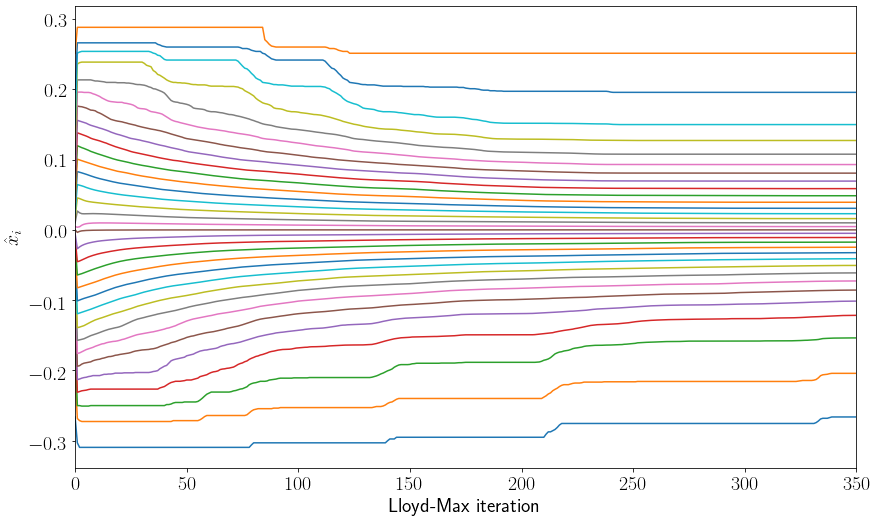

In [31]:
# plot evolution of codebook during training
font = {'size'   : 20}
plt.rc('font', **font)
plt.rc('text', usetex=True)

plt.figure(figsize=(14, 8.5))
for k in range(len(codebook)):
    cb_entries = [codebooks[i][k] for i in range(len(codebooks))]
    plt.plot(range(len(codebooks)), cb_entries)
plt.xlim((0,350))
plt.xlabel('Lloyd-Max iteration')
plt.ylabel('$\hat{x}_i$')
plt.savefig('optimal_codebook_w%d.pdf' % w, bbox_inches='tight')

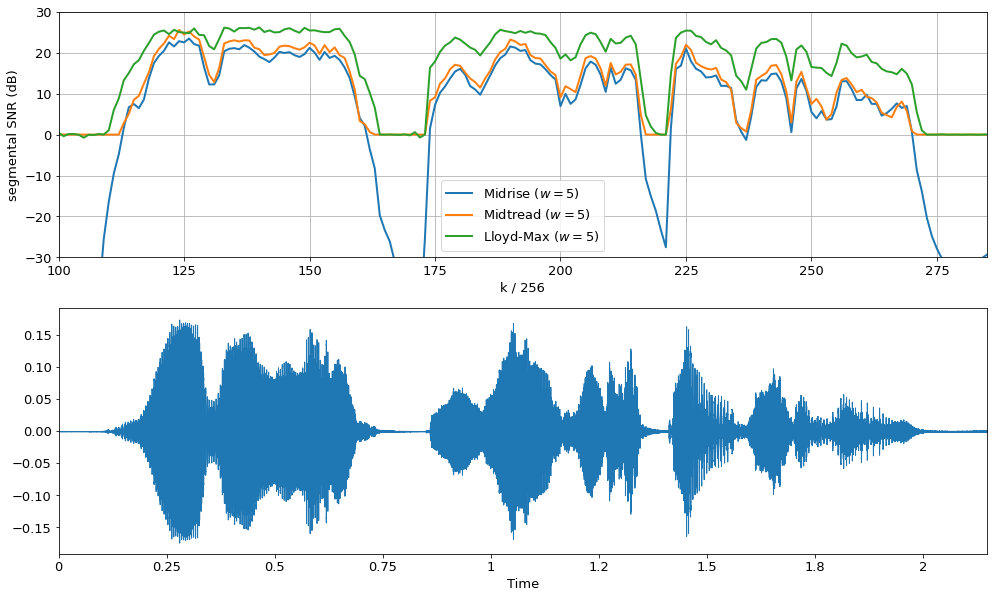

In [32]:
# plot segmental snr
font = {'size'   : 13}
plt.rc('font', **font)
plt.rc('text', usetex=False)

plt.figure(figsize=(14, 8.5))
plt.subplot(2,1,1)
plt.plot(np.arange(segments), snr_uniform_midrise_seg, linewidth=2)
plt.plot(np.arange(segments), snr_uniform_midtread_seg, linewidth=2)
plt.plot(np.arange(segments), snr_nonuniform_seg, linewidth=2)
plt.xlabel('k / %d' % seg_len)
plt.ylabel('segmental SNR (dB)')
plt.ylim((-30,30))
plt.grid()

x_start = 25600 // seg_len
x_stop = 72960 // seg_len

plt.xlim((x_start,x_stop))
plt.legend(['Midrise ($w=5$)','Midtread ($w=5$)','Lloyd-Max ($w=5$)'])

plt.subplot(2,1,2)
librosa.display.waveplot(x[(x_start*seg_len+seg_len//2):(x_stop*seg_len+seg_len//2)], sr=sampling_rate)
plt.tight_layout()

plt.savefig('optimal_segmentalSNR_w%d.pdf' % w, bbox_inches='tight')